# Read the dataset file “labels.csv”
visualizing the data

In [1]:
%matplotlib inline
from os.path import join
import pandas as pd

# relative path
DATA_FILES_PATH = '../Dog-Breed-Classifier/testData/'

# loading labels.csv
INTRO_DF = pd.read_csv(join(DATA_FILES_PATH, 'labels.csv'))

# describe the dataset
INTRO_DF.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


# Breed image distribution

In [2]:
INTRO_DF.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=True).describe()

,id
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


#### Scottish_deerhound being the largest
#### Briard being the smallest

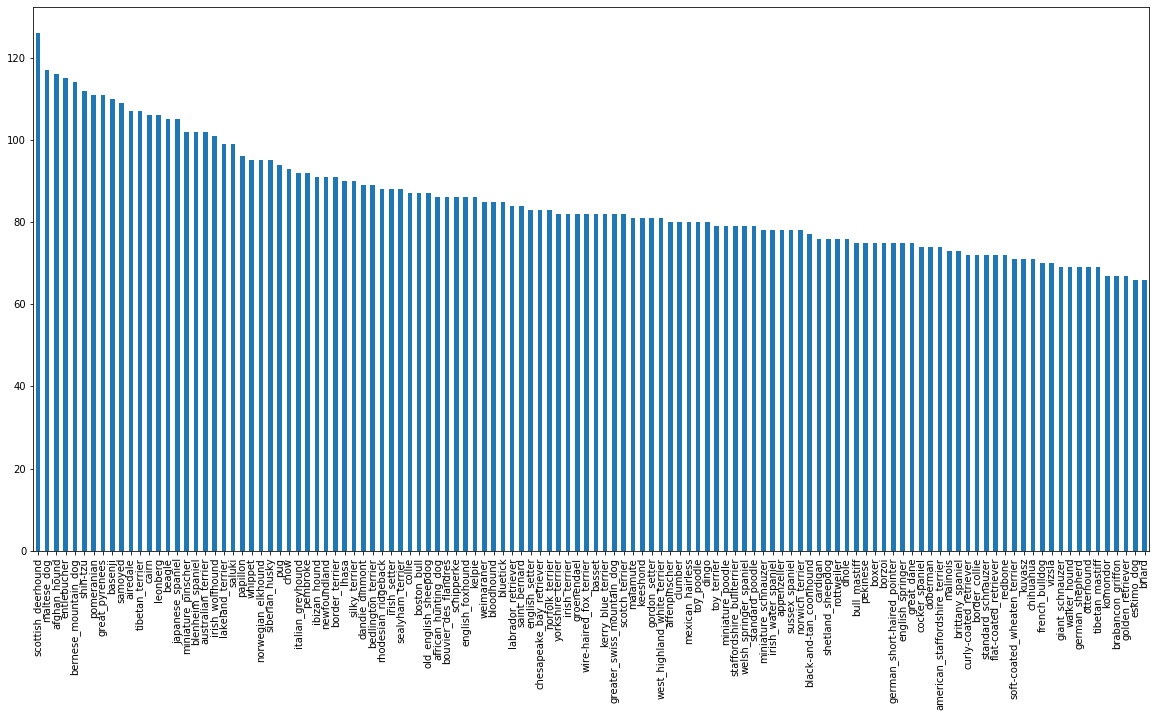

In [3]:
# we can choose from 2 option views

# opition 1
# ax=pd.value_counts(INTRO_DF['breed'],ascending=True).plot(kind='barh',
#                                                        fontsize="40",
#                                                        title=" Dog Distribution",
#                                                        figsize=(50,100))
# ax.set(xlabel="Images per class", ylabel="Classes")
# ax.xaxis.label.set_size(40)
# ax.yaxis.label.set_size(40)
# ax.title.set_size(60)

# opition 2
INTRO_DF["breed"].value_counts().plot.bar(figsize=(20, 10))


In [4]:
uniqueBreeds = INTRO_DF.breed.unique()
# print(uniqueBreeds)
dictBreed = dict(zip(uniqueBreeds,range(len(uniqueBreeds))))
# print(dictBreed)
INTRO_DF['breedNum'] = INTRO_DF['breed'].map(dictBreed)
INTRO_DF[:10]

,id,breed,breedNum
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,5
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,5
7,002a283a315af96eaea0e28e7163b21b,borzoi,6
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,8


## Testing stuff out

In [5]:
labels_dict = {i:j for i,j in zip(INTRO_DF['id'],INTRO_DF['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir(DATA_FILES_PATH+'train')]

In [6]:
if  not os.path.exists('training_images'):
        os.makedirs('training_images')

if  not os.path.exists('validation_images'):
    os.makedirs('validation_images')


In [7]:
os.chdir('training_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)
        #os.rmdir(curClass)

os.chdir('../validation_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

In [8]:
from shutil import copyfile
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in images:
    if count >7999:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
        copyfile(DATA_FILES_PATH+'train/'+item, destination_directory+labels_dict[filekey]+'/'+item)
    print(labels_dict[filekey])
    count +=1

ane
brittany_spaniel
chesapeake_bay_retriever
walker_hound
bull_mastiff
scottish_deerhound
great_dane
wire-haired_fox_terrier
eskimo_dog
malinois
collie
irish_water_spaniel
cocker_spaniel
pekinese
golden_retriever
standard_poodle
boxer
otterhound
basenji
briard
kelpie
greater_swiss_mountain_dog
maltese_dog
irish_setter
shetland_sheepdog
chow
bernese_mountain_dog
pembroke
japanese_spaniel
pembroke
blenheim_spaniel
black-and-tan_coonhound
irish_wolfhound
black-and-tan_coonhound
australian_terrier
border_terrier
boxer
kuvasz
malamute
collie
blenheim_spaniel
rottweiler
whippet
whippet
basenji
afghan_hound
beagle
airedale
malinois
african_hunting_dog
basset
great_dane
blenheim_spaniel
bloodhound
standard_schnauzer
vizsla
border_collie
bedlington_terrier
schipperke
pomeranian
blenheim_spaniel
bull_mastiff
clumber
shetland_sheepdog
kuvasz
border_collie
whippet
wire-haired_fox_terrier
old_english_sheepdog
chihuahua
bouvier_des_flandres
collie
mexican_hairless
boxer
kelpie
bedlington_terrier
bo

Using TensorFlow backend.


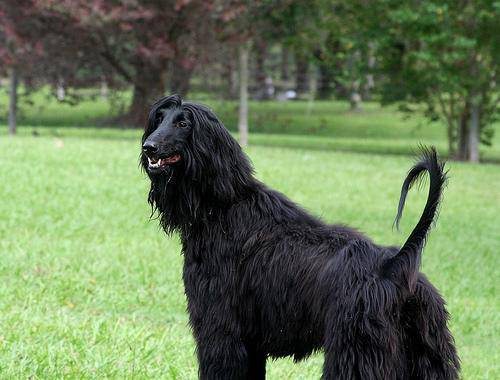

In [9]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img(join(DATA_FILES_PATH, 'train', '0d5a88f0ab2db8d34b533c69768135e8.jpg')) 
img

In [10]:

# datagen = ImageDataGenerator(
#         rotation_range=50,
#         width_shift_range=0.3,
#         height_shift_range=0.2,
#         shear_range=0.3,
#         zoom_range=0.3,
#         horizontal_flip=True,
#         fill_mode='nearest')
 
# x = img_to_array(img)
# x = x.reshape((1,) + x.shape)

# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely

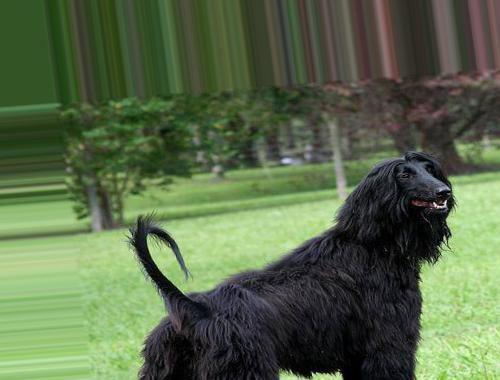

In [11]:
img_preview_path = '../Dog-Breed-Classifier/'
img1=load_img(join(img_preview_path,'preview/dog_breed_0_292.jpeg'))
img1

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D,Dropout
from keras.preprocessing.image import ImageDataGenerator

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.
